In [3]:
import sys
print(sys.executable)


C:\Users\DELL\Desktop\MSE656\torch_env\Scripts\python.exe


In [4]:
import sys
print(sys.executable)


C:\Users\DELL\Desktop\MSE656\torch_env\Scripts\python.exe


Loaded: (427, 21)
['Solute_encoded', 'Solvent_encoded', 'Potential_ID', 'Alpha', 'Mu', 'Sigma', 'solvent_density', 'solvent_shear', 'solute_density', 'solute_shear', 'PC2', 'PC3', 'PC4', 'PC5', 'density_ratio', 'density_diff', 'density_mismatch_pct', 'shear_ratio', 'shear_diff', 'shear_mismatch_pct', 'combined_mismatch']
After dropna: (427, 21)
node_feats shape: (427, 2, 3)
graph_feats shape: (427, 2)
targets shape: (427, 1)
After scaling shapes -> (427, 2, 3) (427, 2) (427,)
Built data_list with 427 graphs
Splits -> train: 300, val: 41, test: 86
Epoch 001 | Train MSE: 525.757609 | Val RMSE: 23.048722 | Best Val RMSE: 23.048722
Epoch 010 | Train MSE: 224.390136 | Val RMSE: 31.065491 | Best Val RMSE: 21.996460
Epoch 020 | Train MSE: 208.666593 | Val RMSE: 31.397718 | Best Val RMSE: 21.996460
Epoch 030 | Train MSE: 214.998688 | Val RMSE: 36.849302 | Best Val RMSE: 21.996460
Early stopping triggered.

Test Performance (target = Mu):
R² Score: -0.0679
MAE: 10.4723
RMSE: 15.9348


C:\Users\DELL\AppData\Local\Temp\ipykernel_11512\894637518.py:320: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_gnn_mu.pth", map_loca

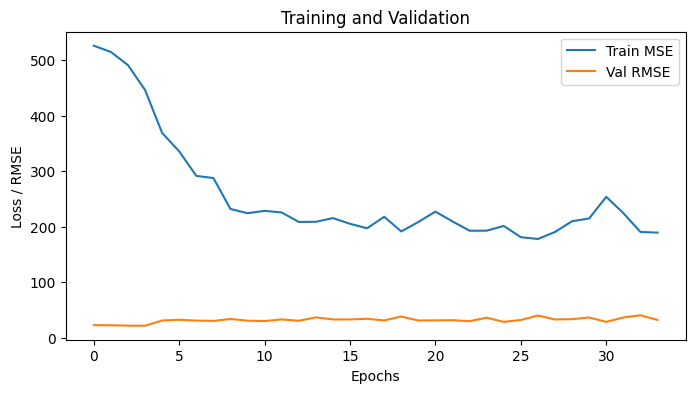

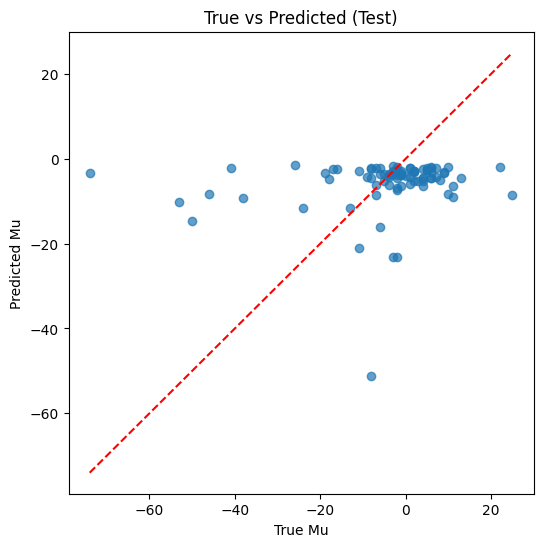

In [6]:
# gnn_for_seg_energy_mu_fixed.py
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_mean_pool, BatchNorm
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---------------------------
# Reproducibility
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# ---------------------------
# 1) Load CSV (processed features)
# ---------------------------
CSV_PATH = "processed_features.csv"   # change if needed
df = pd.read_csv(CSV_PATH)
print("Loaded:", df.shape)
print(df.columns.tolist())

# ---------------------------
# 2) Choose target and node/graph columns
# ---------------------------
target_col = 'Mu'   # user requested target = Mu
assert target_col in df.columns, f"Target {target_col} not found in CSV"

# Encoded element id columns in your file:
solvent_id_col = 'Solvent_encoded'   # integer id per element
solute_id_col  = 'Solute_encoded'

# Node numeric features present in file (these names come from your preview)
node_feat_cols_solvent = ['solvent_density', 'solvent_shear']
node_feat_cols_solute   = ['solute_density', 'solute_shear']

# optional graph-level features present in file
graph_feat_candidates = ['Potential_ID', 'Sigma']   # you can add 'Alpha' or others if needed
graph_feat_cols = [c for c in graph_feat_candidates if c in df.columns]

# Drop rows with NA in used columns
required_cols = [solvent_id_col, solute_id_col, target_col] + node_feat_cols_solvent + node_feat_cols_solute + graph_feat_cols
df = df.dropna(subset=required_cols).reset_index(drop=True)
print("After dropna:", df.shape)

# ---------------------------
# 3) Prepare node features and graph features arrays
# ---------------------------
# Build for each sample a 2-node graph: node0 = solvent, node1 = solute
node_feats = []   # list of (2, Fnode)
graph_feats = []
targets = []

for _, row in df.iterrows():
    # element ids (already encoded integers) -- keep as first column on node features
    solvent_id = np.array([int(row[solvent_id_col])], dtype=float)
    solute_id  = np.array([int(row[solute_id_col])], dtype=float)

    # numeric node parts
    sol_numeric = row[node_feat_cols_solvent].values.astype(float)
    solute_numeric = row[node_feat_cols_solute].values.astype(float)

    node0 = np.concatenate([solvent_id, sol_numeric])   # solvent node
    node1 = np.concatenate([solute_id, solute_numeric]) # solute node

    node_feats.append(np.vstack([node0, node1]))  # shape (2, feat_dim)
    # graph-level features
    if len(graph_feat_cols) > 0:
        gf = row[graph_feat_cols].astype(float).values
    else:
        gf = np.zeros(0)
    graph_feats.append(gf)
    targets.append(float(row[target_col]))

node_feats = np.array(node_feats)   # (N, 2, Fnode)
graph_feats = np.array(graph_feats) # (N, Fgraph) or (N, 0)
targets = np.array(targets, dtype=float).reshape(-1, 1)

print("node_feats shape:", node_feats.shape)
print("graph_feats shape:", graph_feats.shape)
print("targets shape:", targets.shape)

# ---------------------------
# 4) Scale numeric parts (keep id column unscaled)
# ---------------------------
ids = node_feats[:, :, 0].astype(int)   # (N,2)
numeric_parts = node_feats[:, :, 1:].reshape(-1, node_feats.shape[2]-1)  # (N*2, numeric_dim)
scaler_node = StandardScaler()
numeric_parts_scaled = scaler_node.fit_transform(numeric_parts).reshape(node_feats.shape[0], 2, -1)
node_feats_scaled = np.concatenate([ids.reshape(node_feats.shape[0], 2, 1).astype(float), numeric_parts_scaled], axis=2)

# scale graph-level features if exist
if graph_feats.shape[1] > 0:
    scaler_graph = StandardScaler()
    graph_feats_scaled = scaler_graph.fit_transform(graph_feats)
else:
    graph_feats_scaled = np.zeros((node_feats_scaled.shape[0], 0))

# reshape targets (optionally standardize target if needed - here we keep raw Mu)
targets = targets.reshape(-1)

print("After scaling shapes ->", node_feats_scaled.shape, graph_feats_scaled.shape, targets.shape)

# ---------------------------
# 5) Build PyG Data objects (each sample = one small graph with 2 nodes)
# ---------------------------
data_list = []
for i in range(node_feats_scaled.shape[0]):
    x = torch.tensor(node_feats_scaled[i], dtype=torch.float)   # (2, feat_dim)
    # undirected edges (0<->1)
    edge_index = torch.tensor([[0,1,1,0],[1,0,0,1]], dtype=torch.long)
    y = torch.tensor(targets[i], dtype=torch.float).view(1)
    gfeat = torch.tensor(graph_feats_scaled[i], dtype=torch.float) if graph_feats_scaled.shape[1]>0 else torch.empty(0)
    data = Data(x=x, edge_index=edge_index, y=y)
    data.graph_feat = gfeat
    # store integer ids (for embedding) separately for reference (not strictly necessary)
    data.solvent_id = int(ids[i,0])
    data.solute_id  = int(ids[i,1])
    data_list.append(data)

print("Built data_list with", len(data_list), "graphs")

# ---------------------------
# 6) Train / val / test split and DataLoaders
# ---------------------------
train_data, test_data = train_test_split(data_list, test_size=0.2, random_state=SEED)
train_data, val_data = train_test_split(train_data, test_size=0.12, random_state=SEED)  # ~10% val

BATCH_SIZE = 32

# custom collate to collect graph-level features into batch.gfeat_batched
def collate_with_graph_feat(batch_list):
    batch = Batch.from_data_list(batch_list)
    # stack graph feats per sample (len=batch.num_graphs)
    if hasattr(batch_list[0], 'graph_feat') and batch_list[0].graph_feat.numel() > 0:
        gfeats = torch.stack([b.graph_feat for b in batch_list], dim=0).to(batch.x.device if batch.x is not None else torch.device('cpu'))
        batch.gfeat_batched = gfeats
    else:
        # create empty with correct device
        batch.gfeat_batched = torch.empty((batch.num_graphs, 0), device=batch.x.device if batch.x is not None else torch.device('cpu'))
    return batch

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_with_graph_feat)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_with_graph_feat)
test_loader  = DataLoader(test_data,  batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_with_graph_feat)

print(f"Splits -> train: {len(train_data)}, val: {len(val_data)}, test: {len(test_data)}")

# ---------------------------
# 7) GINRegression model (uses element id embedding)
# ---------------------------
class GINRegression(nn.Module):
    def __init__(self, in_channels, emb_dim=32, hidden_dim=64,
                 n_layers=3, num_element_types=None, element_emb_dim=8, graph_feat_dim=0):
        super().__init__()
        self.use_elem_emb = num_element_types is not None
        self.graph_feat_dim = int(graph_feat_dim)  # store for runtime checks

        if self.use_elem_emb:
            self.elem_emb = nn.Embedding(num_element_types, element_emb_dim)
            self.node_num_dim = in_channels - 1  # first col is id
            input_dim = element_emb_dim + self.node_num_dim
        else:
            input_dim = in_channels

        # GIN layers
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(n_layers):
            if i == 0:
                mlp = nn.Sequential(nn.Linear(input_dim, emb_dim), nn.ReLU(), nn.Linear(emb_dim, emb_dim))
            else:
                mlp = nn.Sequential(nn.Linear(emb_dim, emb_dim), nn.ReLU(), nn.Linear(emb_dim, emb_dim))
            self.convs.append(GINConv(mlp))
            self.bns.append(BatchNorm(emb_dim))

        self.pool = global_mean_pool
        final_in = emb_dim + self.graph_feat_dim
        self.fc = nn.Sequential(
            nn.Linear(final_in, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 1)
        )

    def forward(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch if hasattr(data, 'batch') else torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        # replace id column with embedding and concat numeric parts
        if self.use_elem_emb:
            elem_id = x[:, 0].long()
            num_part = x[:, 1:]
            emb = self.elem_emb(elem_id)
            x = torch.cat([emb, num_part], dim=1)

        for conv, bn in zip(self.convs, self.bns):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.relu(x)

        # pool node embeddings to graph embedding
        g = self.pool(x, batch)   # (batch_size, emb_dim)

        # ensure we always have a graph-feature tensor of shape (batch_size, graph_feat_dim)
        if hasattr(data, 'gfeat_batched') and data.gfeat_batched is not None and data.gfeat_batched.numel() > 0:
            gf = data.gfeat_batched.to(g.device)
            # if gf has shape (num_graphs, F) and F matches model.graph_feat_dim, OK
            if gf.size(1) != self.graph_feat_dim:
                # if mismatch, adapt: either truncate or pad with zeros
                if gf.size(1) < self.graph_feat_dim:
                    pad = torch.zeros((gf.size(0), self.graph_feat_dim - gf.size(1)), device=gf.device)
                    gf = torch.cat([gf, pad], dim=1)
                else:
                    gf = gf[:, :self.graph_feat_dim]
        else:
            # create zeros of correct shape
            gf = torch.zeros((g.size(0), self.graph_feat_dim), device=g.device)

        if self.graph_feat_dim > 0:
            g = torch.cat([g, gf], dim=1)

        out = self.fc(g).squeeze(-1)
        return out

# ---------------------------
# 8) Instantiate model, optimizer, loss
# ---------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_element_types = int(max(df[solvent_id_col].max(), df[solute_id_col].max()) + 1)
in_node_dim = node_feats_scaled.shape[2]   # includes id + numeric parts
graph_feat_dim = int(graph_feats_scaled.shape[1]) if graph_feats_scaled.shape[1]>0 else 0

model = GINRegression(in_channels=in_node_dim,
                      emb_dim=64,
                      hidden_dim=128,
                      n_layers=3,
                      num_element_types=int(num_element_types),
                      element_emb_dim=8,
                      graph_feat_dim=graph_feat_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()

# ---------------------------
# 9) Training loop with early stopping (val RMSE)
# ---------------------------
EPOCHS = 200
best_val_rmse = float('inf')
patience = 30
patience_cnt = 0
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        preds = model(batch)
        loss = criterion(preds, batch.y.view(-1).to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch.num_graphs
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # validation
    model.eval()
    preds_all = []
    y_all = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            preds = model(batch)
            preds_all.append(preds.cpu().numpy())
            y_all.append(batch.y.view(-1).cpu().numpy())
    if len(preds_all) == 0:
        val_rmse = float('nan')
    else:
        preds_all = np.concatenate(preds_all)
        y_all = np.concatenate(y_all)
        val_rmse = np.sqrt(mean_squared_error(y_all, preds_all))
    val_losses.append(val_rmse)

    if val_rmse < best_val_rmse - 1e-8:
        best_val_rmse = val_rmse
        patience_cnt = 0
        torch.save(model.state_dict(), "best_gnn_mu.pth")
    else:
        patience_cnt += 1

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Train MSE: {epoch_train_loss:.6f} | Val RMSE: {val_rmse:.6f} | Best Val RMSE: {best_val_rmse:.6f}")

    if patience_cnt >= patience:
        print("Early stopping triggered.")
        break

# ---------------------------
# 10) Evaluate on test set
# ---------------------------
model.load_state_dict(torch.load("best_gnn_mu.pth", map_location=device))
model.to(device)
model.eval()

preds_all = []
y_all = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        preds = model(batch)
        preds_all.append(preds.cpu().numpy())
        y_all.append(batch.y.view(-1).cpu().numpy())

preds_all = np.concatenate(preds_all)
y_all = np.concatenate(y_all)

r2 = r2_score(y_all, preds_all)
mae = mean_absolute_error(y_all, preds_all)
rmse = np.sqrt(mean_squared_error(y_all, preds_all))
print("\nTest Performance (target = Mu):")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# ---------------------------
# 11) Plots
# ---------------------------
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val RMSE')
plt.xlabel('Epochs')
plt.ylabel('Loss / RMSE')
plt.legend()
plt.title('Training and Validation')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_all, preds_all, alpha=0.7)
mn = min(y_all.min(), preds_all.min())
mx = max(y_all.max(), preds_all.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('True Mu')
plt.ylabel('Predicted Mu')
plt.title('True vs Predicted (Test)')
plt.show()


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


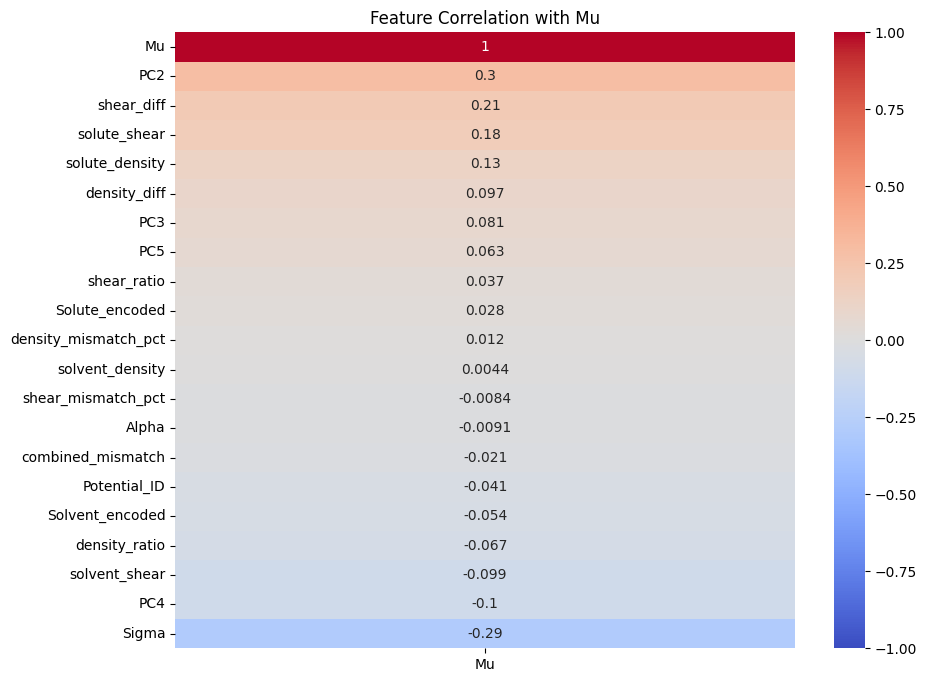

In [10]:
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr[['Mu']].sort_values(by='Mu', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation with Mu")
plt.show()


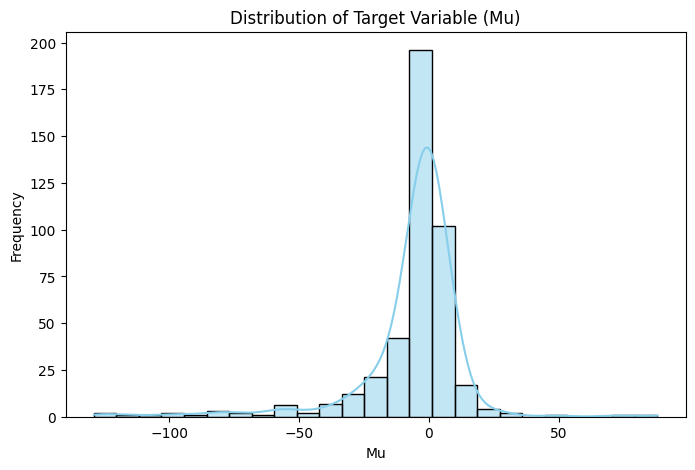

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(df['Mu'], kde=True, bins=25, color='skyblue')
plt.title("Distribution of Target Variable (Mu)")
plt.xlabel("Mu")
plt.ylabel("Frequency")
plt.show()


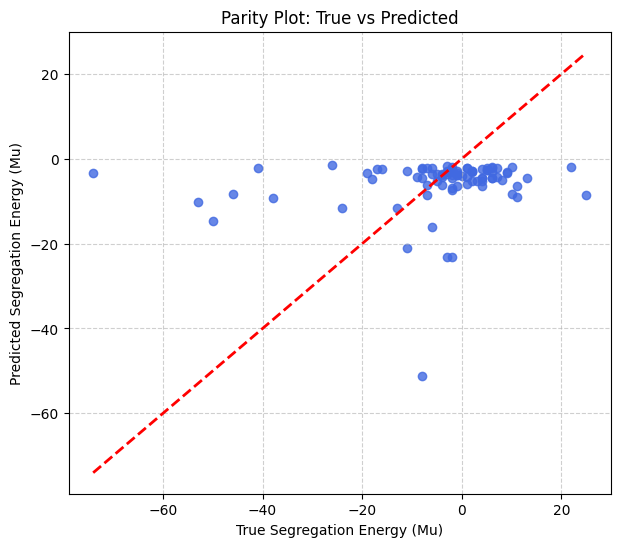

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# y_all = true, preds_all = predicted from test set
plt.figure(figsize=(7,6))
plt.scatter(y_all, preds_all, alpha=0.8, color='royalblue')
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', lw=2)
plt.xlabel("True Segregation Energy (Mu)")
plt.ylabel("Predicted Segregation Energy (Mu)")
plt.title("Parity Plot: True vs Predicted")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


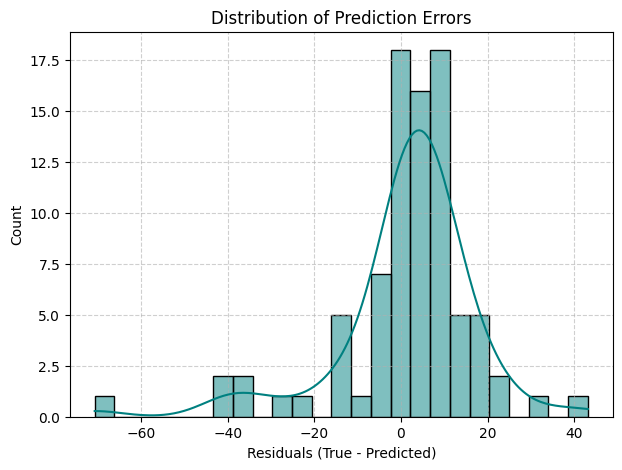

In [19]:
residuals = y_all - preds_all

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True, bins=25, color='teal')
plt.xlabel("Residuals (True - Predicted)")
plt.title("Distribution of Prediction Errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


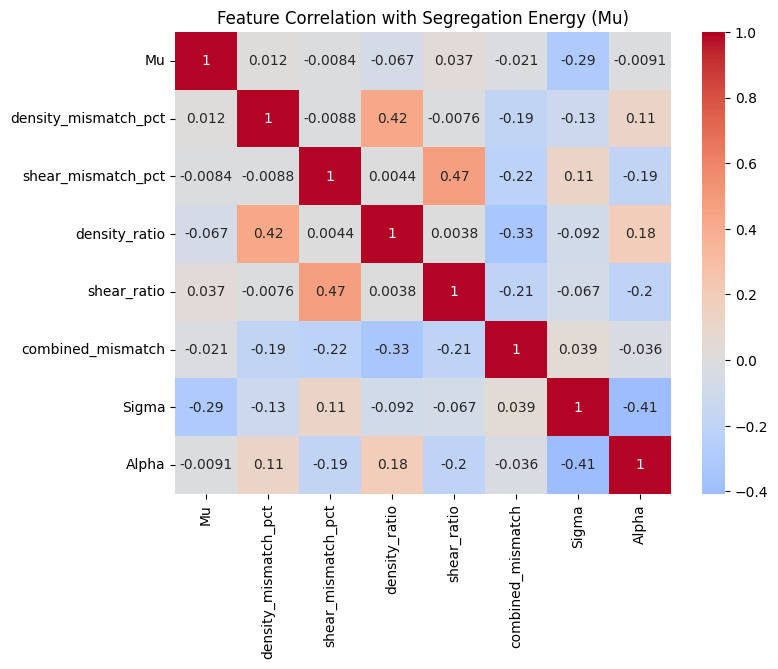

In [21]:
corr_features = ['Mu', 'density_mismatch_pct', 'shear_mismatch_pct', 
                 'density_ratio', 'shear_ratio', 'combined_mismatch', 'Sigma', 'Alpha']

corr_df = df[corr_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Correlation with Segregation Energy (Mu)")
plt.show()


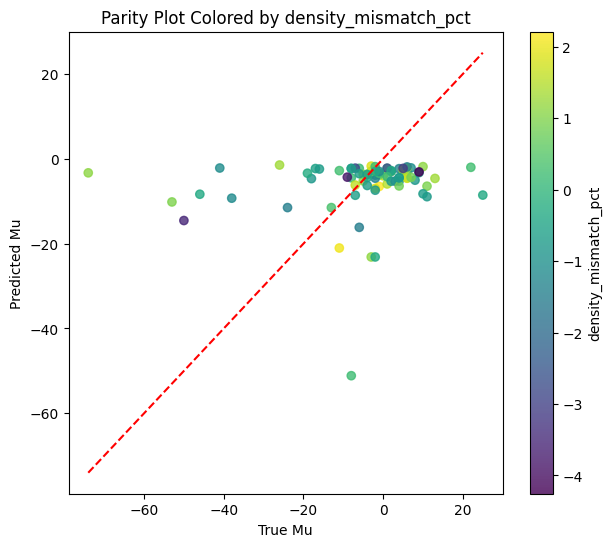

In [23]:
# Color points by density mismatch
feature = 'density_mismatch_pct'
plt.figure(figsize=(7,6))
sc = plt.scatter(y_all, preds_all, c=df[feature].iloc[-len(y_all):], cmap='viridis', alpha=0.8)
plt.colorbar(sc, label=feature)
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--')
plt.xlabel("True Mu")
plt.ylabel("Predicted Mu")
plt.title(f"Parity Plot Colored by {feature}")
plt.show()


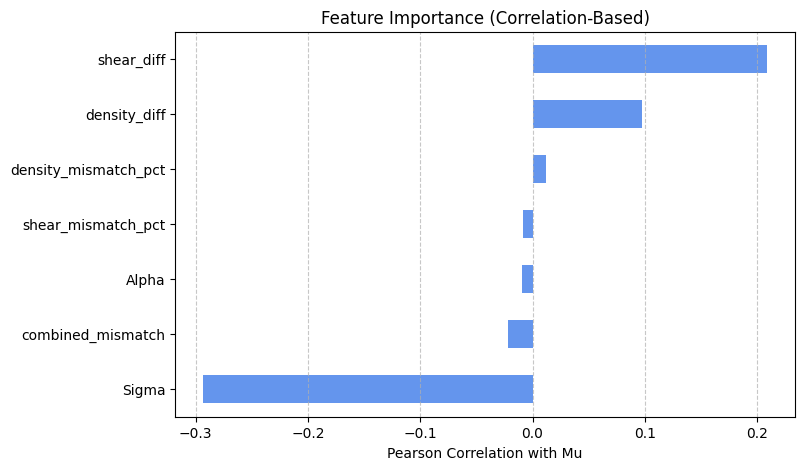

In [24]:
num_cols = ['density_mismatch_pct','shear_mismatch_pct','combined_mismatch',
            'density_diff','shear_diff','Sigma','Alpha']
corrs = df[num_cols + ['Mu']].corr()['Mu'].drop('Mu').sort_values()

plt.figure(figsize=(8,5))
corrs.plot(kind='barh', color='cornflowerblue')
plt.xlabel('Pearson Correlation with Mu')
plt.title('Feature Importance (Correlation-Based)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()
